In [11]:
import pandas as pd
from pymongo import MongoClient
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as ticker
from matplotlib.colors import LogNorm, Normalize


from utils import (
    extrapolated_multiitemp_lambdahat
)
from dln import (
    true_dln_learning_coefficient
)
import json
import os
from datetime import datetime

import seaborn as sns
sns.set()
sns.set_style("whitegrid")

# mpl.use('pdf')
plt.rc('font', family='serif', serif='Times')
plt.rc('text', usetex=True)
plt.rc('xtick', labelsize=11)
plt.rc('ytick', labelsize=11)
plt.rc('axes', labelsize=11)

IMAGEDIR = "./images/autogenerated_testrun/"
DRYRUN = False
OPEN_SAVEDIMAGES = True
BURN_IN = 49000

os.makedirs(IMAGEDIR, exist_ok=True)

def _generate_filepath(name):
    filepath = os.path.join(IMAGEDIR, name)
    print(f"Saving file at: {filepath}")
    if os.path.exists(filepath):
        print(f"Warning: Overwriting existing file: {filepath}")
    return filepath

def savefig_fn(fig, name):
    filepath = _generate_filepath(name)
    if not DRYRUN:
        fig.savefig(filepath, bbox_inches="tight")
        if OPEN_SAVEDIMAGES:
            os.system(f"open {filepath}")
    else:
        print("DRY RUN, figure not saved.")
    return


def extract_data(subdir):
    with open(os.path.join(subdir, 'config.json'), 'r') as f:
        config = json.load(f)

    with open(os.path.join(subdir, 'info.json'), 'r') as f:
        info = json.load(f)
    doc = {"config": config, "info": info}

    data = {
        "epsilon": config.get('sgld_config', {}).get('epsilon'),
        "num_steps": config.get('sgld_config', {}).get('num_steps'),
        "input_dim": config.get('input_dim'),
        "layer_widths": config.get('layer_widths'),
        "num_training_data": config.get('num_training_data'),
        "itemp": config.get('itemp'),
        "do_training": config.get("do_training"), 
        "lambdahat": info.get('lambdahat'),
        "true_lambda": info.get('true_lambda'),
        "true_rank": info.get('true_rank'),
        "loss_trace": info.get('loss_trace'),
        "init_loss": info.get('init_loss'),
        "true_multiplicity": info.get('true_multiplicity'),
        "lambdahat_trained": info.get('trained_param_info', {}).get('lambdahat'),
        "loss_trace_trained": info.get("trained_param_info", {}).get("loss_trace"),
        "init_loss_trained": info.get("trained_param_info", {}).get("init_loss"),
        "model_dim": info.get('model_dim'),
        "functional_rank": info.get('functional_rank_info', {}).get('functional_rank'),
        "hessian_trace_estimate": info.get('hessian_trace_estimate'),
        "svdvals": info.get('functional_rank_info', {}).get('singular_values'), 
        "mala_acceptance_probs": info.get("mala_acceptance_probs")
    }
    return data, doc

def extract_directory(directory_path):
    all_data = []

    for subdir in os.listdir(directory_path):
        full_subdir_path = os.path.join(directory_path, subdir)
        if subdir == "_sources" or not os.path.isdir(full_subdir_path):
            continue
        if set(["info.json", "config.json"]).issubset(set(os.listdir(full_subdir_path))):
            try: 
                data, doc = extract_data(full_subdir_path)
                data["_id"] = int(subdir)
                data["dirname"] = os.path.basename(directory_path)
                all_data.append(data)
                sample_doc = doc
            except:
                print("ERROR: ", full_subdir_path)
    return all_data, sample_doc

def postprocess_df(df_data):
    df_data["avg_width"] = [np.mean(x) for x in df_data["layer_widths"]]
    df_data["num_layers"] = [len(x) for x in df_data["layer_widths"]]
    df_data["first_nan_index"] = [
        list(np.isnan(trace)).index(True) if np.any(np.isnan(trace)) else None 
        for trace in df_data["loss_trace"]
    ]

    if "lambdahat_with_burnin" not in df_data.columns:
        results = []
        for i, row in df_data.iterrows():
            losses = row["loss_trace"]
            init_loss = row["init_loss"]
            n = row["num_training_data"]
            lambdahat_burnin = (np.mean(losses[BURN_IN:]) - init_loss) * n / np.log(n)
            results.append(lambdahat_burnin)
        df_data["lambdahat_with_burnin"] = results

    if "loss_trace_trained" in df_data.columns:
        results = []
        for i, row in df_data.iterrows():
            if not row["do_training"]:
                results.append(None)
                continue
            try:
                losses = row["loss_trace_trained"]
                init_loss = row["init_loss_trained"]
                n = row["num_training_data"]
                lambdahat_trained_burnin = (np.mean(losses[BURN_IN:]) - init_loss) * n / np.log(n)
                results.append(lambdahat_trained_burnin)
            except:
                print(f"ERROR: init_loss: {init_loss}, losses: {losses}")
                results.append(None)
        df_data["lambdahat_trained_with_burnin"] = results
    return df_data


In [4]:


directory_paths = [
    # "./spartan_outputs/rand_rank_batch500_width500-2000_layer2-20_trainFalse_n500000_202401252345",
    # "./spartan_outputs/rand_rank_batch500_width100-1000_layer2-20_trainFalse_n1000000_202401261737",
    # "./spartan_outputs/rand_rank_batch500_width50-300_layer2-20_trainFalse_n1000000_202401261740",
    
    # "./spartan_outputs/zero_batch500_width50-300_layer2-20_trainFalse_n1000000_202401270024",
    # "./spartan_outputs/zero_batch500_width100-1000_layer2-20_trainFalse_n1000000_202401270027",
    # "./spartan_outputs/zero_batch500_width100-1000_layer2-20_trainFalse_n1000000_202401271744",

    # "./spartan_outputs/random_batch500_width50-300_layer2-20_trainFalse_n1000000_202401272350",
    # "./spartan_outputs/random_batch500_width100-1000_layer2-20_trainFalse_n1000000_202401272350",


    
    "./spartan_outputs/rand_rank_batch500_width50-300_layer2-20_trainTrue_n1000000_eps1e-07_nstep50000_202401281612", 
    "./spartan_outputs/rand_rank_batch500_width100-1000_layer2-20_trainTrue_n1000000_eps2e-08_nstep50000_202401281611", 
    "./spartan_outputs/rand_rank_batch500_width500-2000_layer2-20_trainTrue_n500000_eps2e-08_nstep50000_202401290107",
    # "./spartan_outputs/rand_rank_batch500_width500-3000_layer2-40_trainTrue_n1000000_eps1e-08_nstep50000_202401292225",
    # "./spartan_outputs/rand_rank_batch500_width500-3000_layer2-40_trainTrue_n1000000_eps2e-08_nstep50000_202401300014",
    "./spartan_outputs/rand_rank_batch500_width500-3000_layer20-40_trainFalse_n1000000_eps1e-08_nstep100000_202401300258",
    

    # "./spartan_outputs/zero_batch500_width50-300_layer2-20_trainTrue_n1000000_eps5e-07_nstep50000_202401290235", 
    # "./spartan_outputs/zero_batch500_width100-1000_layer2-20_trainTrue_n1000000_eps1e-07_nstep50000_202401290736",
    # "./spartan_outputs/zero_batch500_width500-2000_layer2-20_trainTrue_n1000000_eps2e-08_nstep50000_202401290736"
    # "./spartan_outputs/zero_batch500_width500-3000_layer2-40_trainTrue_n500000_eps1e-08_nstep50000_202401291345",
    # "./spartan_outputs/zero_batch500_width500-3000_layer2-40_trainTrue_n500000_eps5e-09_nstep50000_202401291345",
]


all_data = []
for dirpath in directory_paths:
    data, sample_doc = extract_directory(dirpath)
    all_data += data


current_datetime = datetime.now().strftime("%Y%d%m%H%M")
EXPT_NAME = f"plot{hash(tuple(directory_paths))}"

# Convert to pandas DataFrame
df_data = pd.DataFrame(all_data)
df_data = postprocess_df(df_data)
print(df_data.shape)
print(json.dumps(sample_doc["config"], indent=2))

ERROR:  ./spartan_outputs/rand_rank_batch500_width500-3000_layer20-40_trainFalse_n1000000_eps1e-08_nstep100000_202401300258/16
ERROR: init_loss: nan, losses: None
(390, 28)
{
  "do_compute_distance": false,
  "do_functional_rank": false,
  "do_hessian_trace": false,
  "do_training": false,
  "expt_name": "rand_rank_batch500_width500-3000_layer20-40_trainFalse_n1000000_eps1e-08_nstep100000_202401300258",
  "input_dim": 1328,
  "input_dist": "uniform",
  "itemp": 0.07238241365054197,
  "layer_widths": [
    1440,
    1439,
    2057,
    829,
    903,
    1191,
    2420,
    1739,
    2386,
    1739,
    1907,
    2174,
    1082,
    520,
    2558,
    2488,
    2933,
    777,
    872,
    1449,
    2228,
    519,
    2798,
    2042,
    1119,
    1378,
    2717,
    1801,
    1903,
    1545,
    1011,
    2303,
    1578,
    1832,
    941,
    1194,
    1681
  ],
  "loss_trace_minibatch": true,
  "num_test_data": 100,
  "num_training_data": 1000000,
  "param_init": null,
  "save_true_par

# Main Figure: $\hat{\lambda}$-vs-$\lambda$

Saving file at: ./images/autogenerated_testrun/lambdahat_vs_lambda.pdf


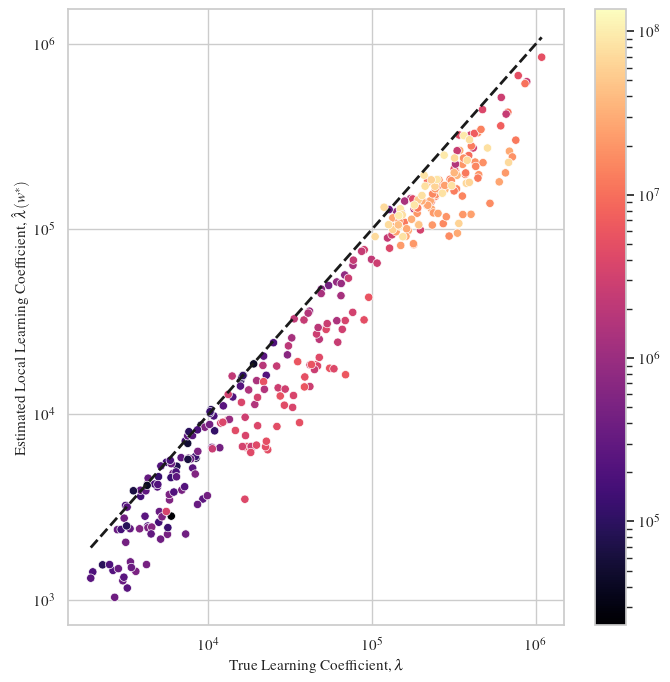

In [109]:
df = df_data
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
cmap = "magma"

vals = np.linspace(df["true_lambda"].min(), df["true_lambda"].max(), num=50)
ax.plot(vals, vals, "k--", linewidth=2)
sns.scatterplot(
    data=df, 
    x="true_lambda", 
    y="lambdahat_with_burnin", 
    hue="model_dim", 
    hue_norm=LogNorm(), 
    palette=cmap, 
    ax=ax
)

sm = plt.cm.ScalarMappable(cmap=cmap, norm=LogNorm(df["model_dim"].min(), df["model_dim"].max()))
sm.set_array([])
ax.get_legend().remove()
ax.figure.colorbar(sm, ax=ax)

ax.set_xlabel("True Learning Coefficient, $\lambda$")
ax.set_ylabel("Estimated Local Learning Coefficient, $\hat{\lambda}(w^*)$")
ax.set_xscale("log")
ax.set_yscale("log")
savefig_fn(fig, "lambdahat_vs_lambda.pdf")


# Linear-scale $\hat{\lambda}$-vs-$\lambda$

Saving file at: ./images/autogenerated_testrun/lambdahat_vs_lambda_linearscale.pdf


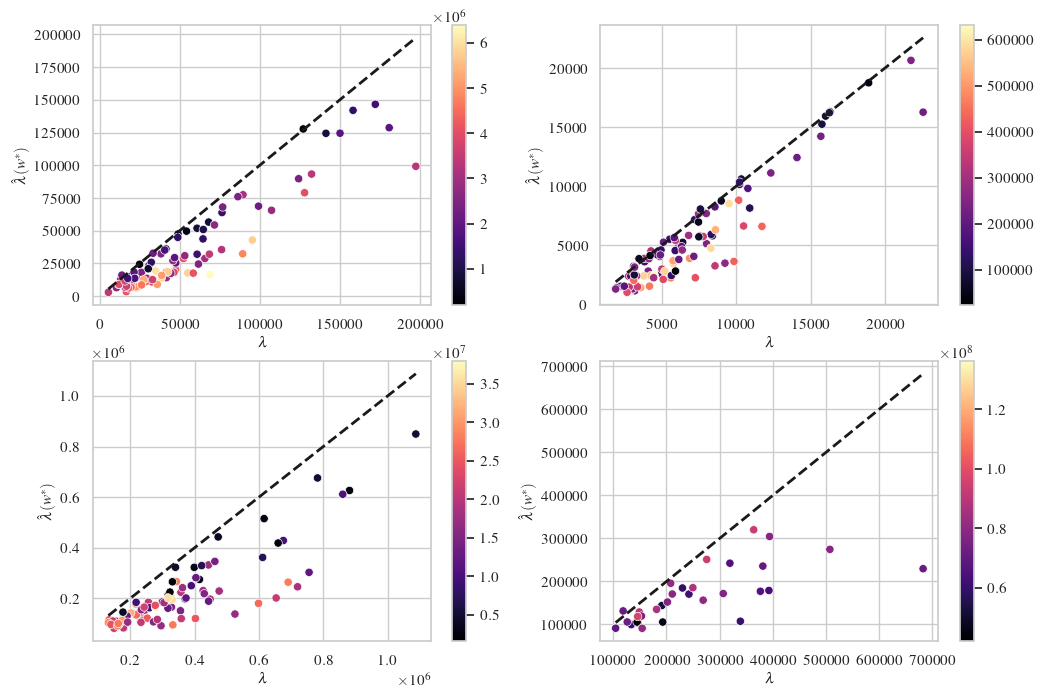

In [111]:
df_plot = df_data
group = df_plot.groupby("dirname")
cmap = "magma"

num_plot = len(group.groups)
nrows = 2
ncols = num_plot // nrows + int(num_plot % nrows != 0)
fig, axes = plt.subplots(nrows, ncols, figsize=(6 * ncols, 4 * nrows))
axes = np.ravel(axes)

for i, (name, df) in enumerate(group):
    ax = axes[i]
    vals = np.linspace(df["true_lambda"].min(), df["true_lambda"].max(), num=50)
    ax.plot(vals, vals, "k--", linewidth=2)
    sns.scatterplot(
        data=df, 
        x="true_lambda", 
        y="lambdahat_with_burnin", 
        hue="model_dim", 
        # hue_norm=LogNorm(), 
        palette=cmap, 
        ax=ax
    )

    sm = plt.cm.ScalarMappable(cmap=cmap, norm=Normalize(df["model_dim"].min(), df["model_dim"].max()))
    sm.set_array([])
    ax.get_legend().remove()
    ax.figure.colorbar(sm, ax=ax)

    ax.set_xlabel("$\lambda$")
    ax.set_ylabel("$\hat{\lambda}(w^*)$")
savefig_fn(fig, "lambdahat_vs_lambda_linearscale.pdf")

# $\hat{\lambda}$-vs-$\lambda$ at trained parameter

Saving file at: ./images/autogenerated_testrun/lambdahat_vs_lambda_trained_param.pdf


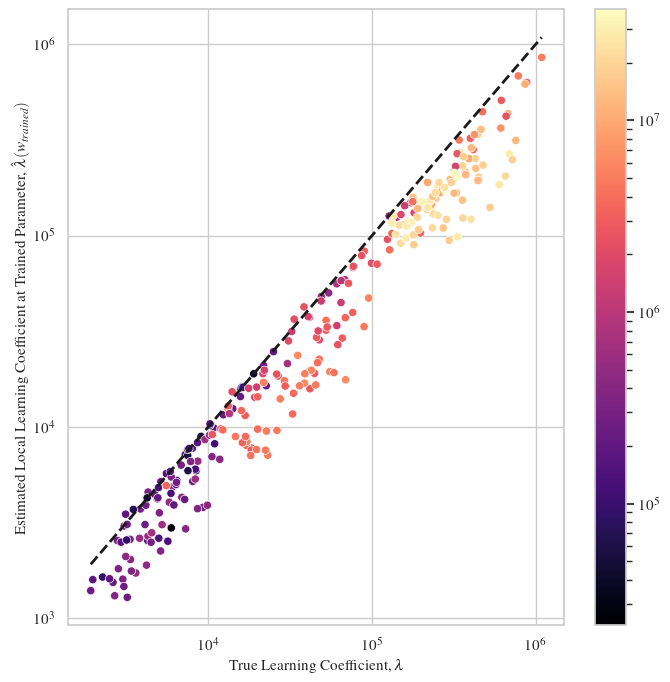

In [112]:
df = df_data
df = df[df["do_training"]]
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
cmap = "magma"

vals = np.linspace(df["true_lambda"].min(), df["true_lambda"].max(), num=50)
ax.plot(vals, vals, "k--", linewidth=2)
sns.scatterplot(
    data=df, 
    x="true_lambda", 
    y="lambdahat_trained_with_burnin", 
    hue="model_dim", 
    hue_norm=LogNorm(), 
    palette=cmap, 
    ax=ax
)

sm = plt.cm.ScalarMappable(cmap=cmap, norm=LogNorm(df["model_dim"].min(), df["model_dim"].max()))
sm.set_array([])
ax.get_legend().remove()
ax.figure.colorbar(sm, ax=ax)

ax.set_xlabel("True Learning Coefficient, $\lambda$")
ax.set_ylabel("Estimated Local Learning Coefficient at Trained Parameter, $\hat{\lambda}(w_{trained})$")
ax.set_xscale("log")
ax.set_yscale("log")
savefig_fn(fig, "lambdahat_vs_lambda_trained_param.pdf")


# Multiplicity 

Saving file at: ./images/autogenerated_testrun/multiplicity_barchart.pdf


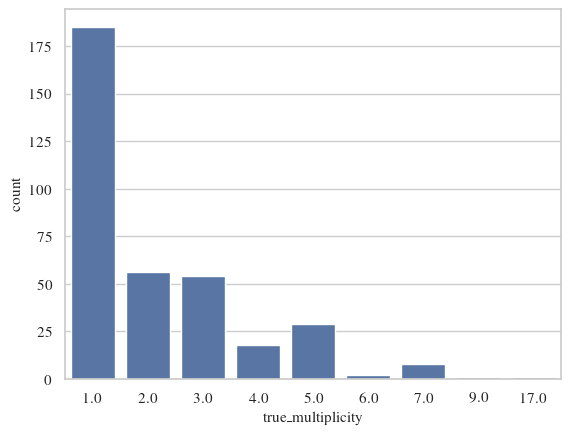

In [43]:
df = df_data
fig, ax = plt.subplots()
sns.countplot(data=df, x="true_multiplicity", ax=ax)
savefig_fn(fig, "multiplicity_barchart.pdf")

# Loss Trace

Saving file at: ./images/autogenerated_testrun/loss_trace_timeseries.pdf


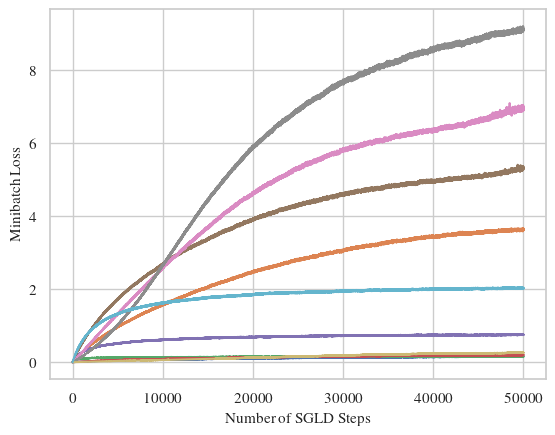

In [23]:
df = df_data
df = df[~np.isnan(df["lambdahat"])]
fig, ax = plt.subplots()

indices = np.random.randint(0, df.shape[0], size=10)
for index in indices: 
    sample_loss_trace = np.array(df.iloc[index]["loss_trace"])
    n = df.iloc[index]["num_training_data"]
    nsamples = len(sample_loss_trace)
    ax.plot(list(range(nsamples)), sample_loss_trace)
ax.set_xlabel("Number of SGLD Steps")
ax.set_ylabel("Minibatch Loss")
savefig_fn(fig, "loss_trace_timeseries.pdf")

# MALA acceptance probabilities

191 0.7055855085005053
22 0.9823218806385994
116 0.8600010111059994
206 0.8965503677621484
316 0.5934611068098263
Saving file at: ./images/autogenerated_testrun/mala_accept_prob_trace.pdf


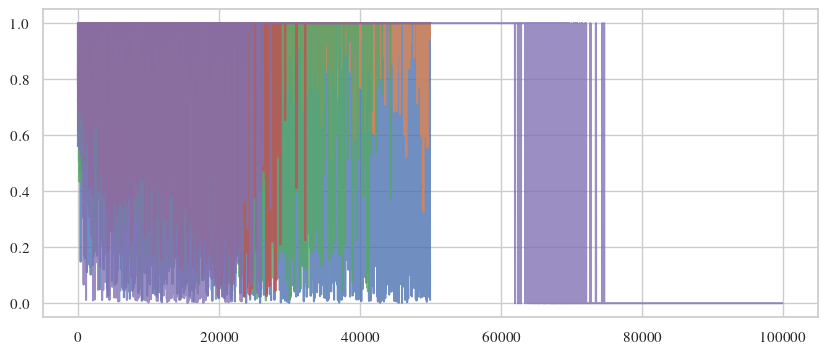

In [49]:
df = df_data
df = df[~np.isnan(df["lambdahat"])]

indices = np.random.choice(df.shape[0], size=5, replace=False)
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
for index in indices:
    probs = np.array(df.iloc[index]["mala_acceptance_probs"])
    print(index, np.mean(probs[:, 1]))    
    ax.plot(probs[:, 0], probs[:, 1], alpha=0.8)

savefig_fn(fig, "mala_accept_prob_trace.pdf")

Saving file at: ./images/autogenerated_testrun/mean_mala_acceptprobs_histogram.pdf


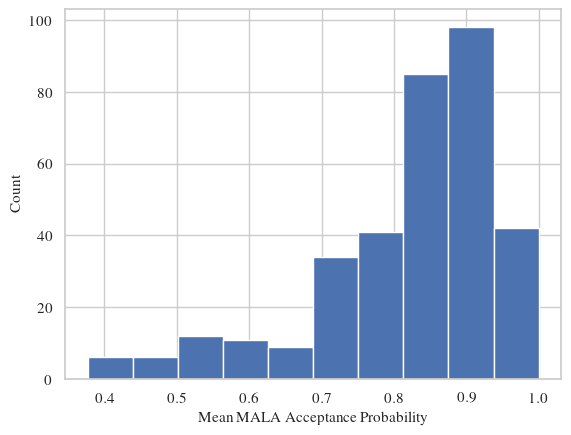

In [119]:
df = df_data
df = df[~np.isnan(df["lambdahat"])]
fig, ax = plt.subplots()

probs = [np.array(x)[:, 1].mean() for x in df["mala_acceptance_probs"]]

ax.hist(probs)
ax.set_xlabel("Mean MALA Acceptance Probability")
ax.set_ylabel("Count")
savefig_fn(fig, "mean_mala_acceptprobs_histogram.pdf")

# Rescaling-invariant Experiment plots

Saving file at: ./images/autogenerated_testrun/rescaling_invariance_lambdahat_vs_scale.pdf


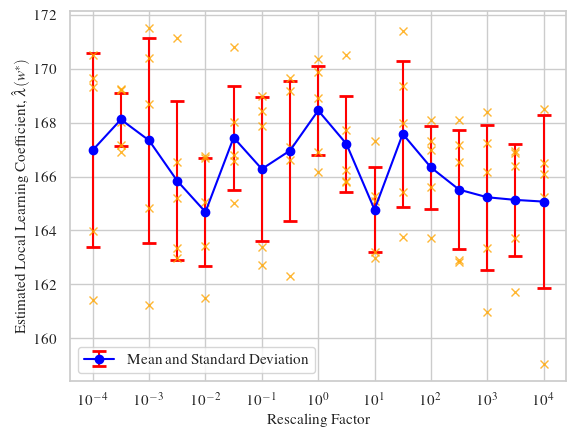

In [114]:
with open("llc_rescaling_results.json") as infile:
    results = json.load(infile)
    scaling_factors = results["scaling_factors"]
    lambdahats = np.array(results["lambdahats"])

fig, ax = plt.subplots()
meanvals = lambdahats.mean(axis=1)
stds = lambdahats.std(axis=1)
ax.errorbar(
    scaling_factors, 
    meanvals, 
    yerr=stds, 
    fmt='o-', 
    capsize=5, 
    capthick=2, 
    ecolor='red', 
    color='blue', 
    label='Mean and Standard Deviation'
)
ax.set_xlabel("Rescaling Factor")
ax.set_ylabel("Estimated Local Learning Coefficient, $\hat{\lambda}(w^*)$")
ax.set_xscale("log")
ax.legend()
for i in range(lambdahats.shape[1]):
    ax.plot(scaling_factors, lambdahats[:, i], "x", alpha=0.8, c="orange")

savefig_fn(fig, "rescaling_invariance_lambdahat_vs_scale.pdf")

# MALA vs SGLD plot

Saving file at: ./images/autogenerated_testrun/sampler_comparison_lambdahat.pdf
Saving file at: ./images/autogenerated_testrun/sampler_comparison_exectime.pdf


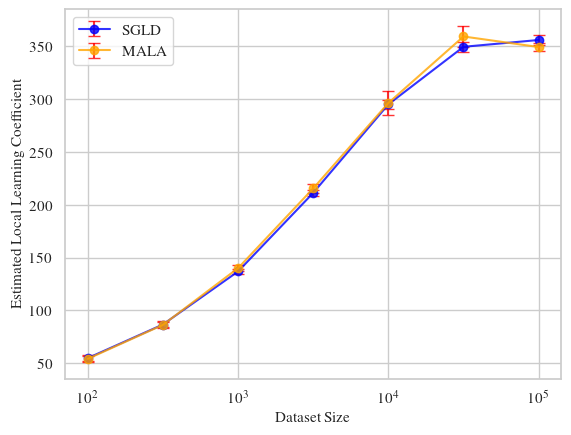

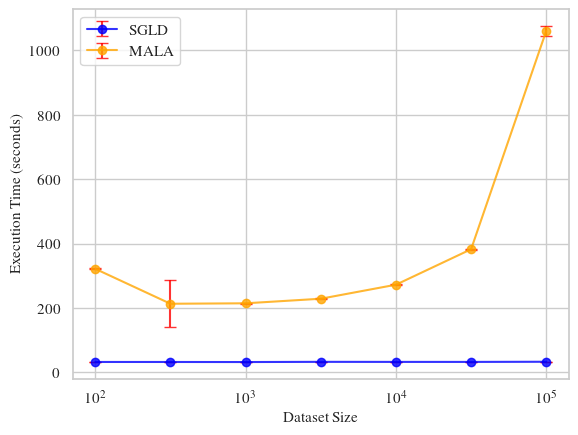

In [113]:
with open("./data/mala_v_sgld_results.json") as infile:
    results = json.load(infile)
    dataset_sizes = results["dataset_sizes"]


fig, ax = plt.subplots(1, 1)
color_dict = {
    "SGLD": "blue", 
    "MALA": "orange"
}
for method in color_dict:
    vals = np.array(results[method]["lambdas"])
    meanvals = vals.mean(axis=1)
    stds = vals.std(axis=1)
    ax.errorbar(
        dataset_sizes, 
        meanvals, 
        yerr=stds, 
        fmt='o-', 
        capsize=4, 
        capthick=1, 
        ecolor='red', 
        color=color_dict[method], 
        label=f"{method}", 
        alpha=0.8
    )
ax.legend()
ax.set_xlabel("Dataset Size")
ax.set_ylabel("Estimated Local Learning Coefficient")
ax.set_xscale("log")
savefig_fn(fig, "sampler_comparison_lambdahat.pdf")

fig, ax = plt.subplots(1, 1)
for method in color_dict:
    vals = np.array(results[method]["times"])
    meanvals = vals.mean(axis=1)
    stds = vals.std(axis=1)
    ax.errorbar(
        dataset_sizes, 
        meanvals, 
        yerr=stds, 
        fmt='o-', 
        capsize=4, 
        capthick=1, 
        ecolor='red', 
        color=color_dict[method], 
        label=f"{method}", 
        alpha=0.8
    )
ax.legend()
ax.set_xlabel("Dataset Size")
ax.set_ylabel("Execution Time (seconds)")
ax.set_xscale("log")
savefig_fn(fig, "sampler_comparison_exectime.pdf")

# Volume Scaling Cartoon

Saving file at: ./images/autogenerated_testrun/volume_scaling_cartoon.pdf


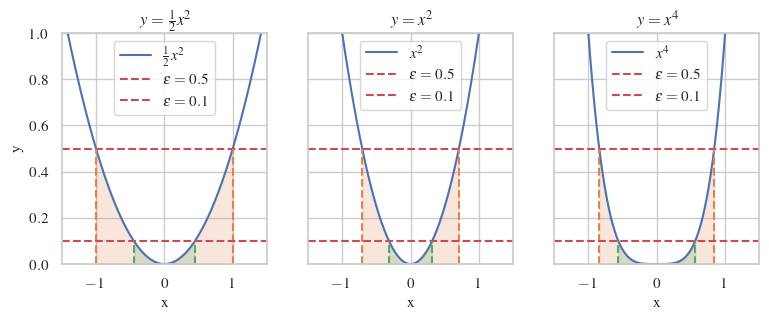

In [120]:
# Define the range of x values and two levels of epsilon
x_values = np.linspace(-1.5, 1.5, 400)
epsilon1 = 0.5
epsilon2 = 0.1

# Calculate y values for x^2, 1/2 x^2, and x^4
y_squared = x_values**2
y_half_squared = 0.5 * x_values**2
y_quartic = x_values**4

# Create the figure and axes objects
fig, axs = plt.subplots(1, 3, figsize=(9, 3), sharey=True)

# Plot 1/2 x^2, vertical lines, and shaded area for two epsilon levels
axs[0].plot(x_values, y_half_squared, label='$\\frac{1}{2}x^2$')
for idx, epsilon in enumerate([epsilon1, epsilon2]):
    axs[0].axhline(y=epsilon, color='r', linestyle='--', label=f'$\epsilon = {epsilon}$')
    x_range = np.sqrt(2 * epsilon)
    axs[0].vlines(x=[-x_range, x_range], ymin=0, ymax=epsilon, color=f'C{idx+1}', linestyle='--')
    axs[0].fill_between(x_values, y_half_squared, where=(np.abs(x_values) <= x_range), alpha=0.2, color=f'C{idx+1}')
axs[0].set_xlabel('x')
axs[0].set_ylabel('y')
axs[0].set_title('$y = \\frac{1}{2}x^2$')
axs[0].legend()

# Plot x^2, vertical lines, and shaded area for two epsilon levels
axs[1].plot(x_values, y_squared, label='$x^2$')
for idx, epsilon in enumerate([epsilon1, epsilon2]):
    axs[1].axhline(y=epsilon, color='r', linestyle='--', label=f'$\epsilon = {epsilon}$')
    x_range = np.sqrt(epsilon)
    axs[1].vlines(x=[-x_range, x_range], ymin=0, ymax=epsilon, color=f'C{idx+1}', linestyle='--')
    axs[1].fill_between(x_values, y_squared, where=(np.abs(x_values) <= x_range), alpha=0.2, color=f'C{idx+1}')
axs[1].set_xlabel('x')
axs[1].set_title('$y = x^2$')
axs[1].legend()

# Plot x^4, vertical lines, and shaded area for two epsilon levels
axs[2].plot(x_values, y_quartic, label='$x^4$')
for idx, epsilon in enumerate([epsilon1, epsilon2]):
    axs[2].axhline(y=epsilon, color='r', linestyle='--', label=f'$\epsilon = {epsilon}$')
    x_range = epsilon**(1/4)
    axs[2].vlines(x=[-x_range, x_range], ymin=0, ymax=epsilon, color=f'C{idx+1}', linestyle='--')
    axs[2].fill_between(x_values, y_quartic, where=(np.abs(x_values) <= x_range), alpha=0.2, color=f'C{idx+1}')
axs[2].set_xlabel('x')
axs[2].set_title('$y = x^4$')
axs[2].legend()

# Set the same x and y-axis limits for all subplots
for ax in axs:
    ax.set_xlim([-1.5, 1.5])
    ax.set_ylim([0, 1])

savefig_fn(fig, "volume_scaling_cartoon.pdf")


# MISC

Saving file at: ./images/autogenerated_testrun/model_dimension_histogram.pdf


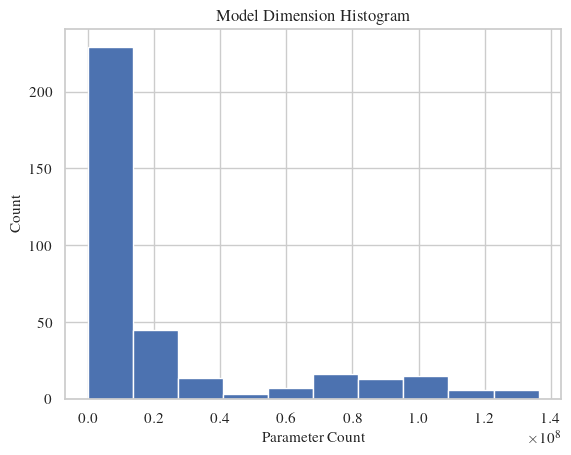

In [13]:
fig, ax = plt.subplots()
ax.hist(df_data["model_dim"])
ax.set_title("Model Dimension Histogram");
ax.set_xlabel("Parameter Count")
ax.set_ylabel("Count")
# ax.set_xscale("log")
savefig_fn(fig, "model_dimension_histogram.pdf")

lambdahat
False    344
True      46
Name: count, dtype: int64


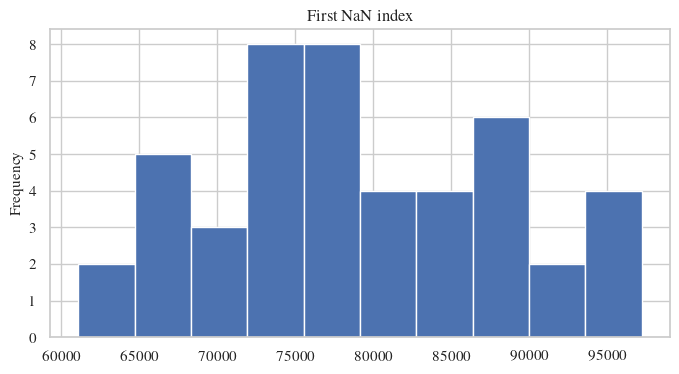

In [18]:
nan_count = np.isnan(df_data["lambdahat"]).value_counts()
print(nan_count)

if True in nan_count.index:
    fig, ax = plt.subplots(1, 1, figsize=(8, 4))
    df_data["first_nan_index"].plot(kind="hist", ax=ax)
    ax.set_title("First NaN index");

Saving file at: ./images/autogenerated_testrun/lambdahat_relative_error_histogram.pdf
Saving file at: ./images/autogenerated_testrun/lambdahat_relative_error_scatterplot.pdf


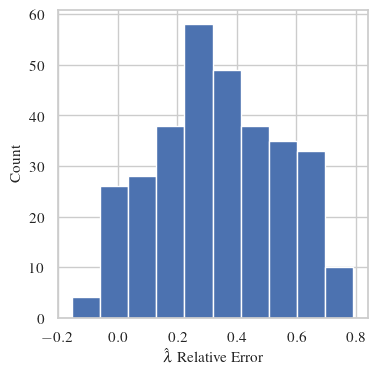

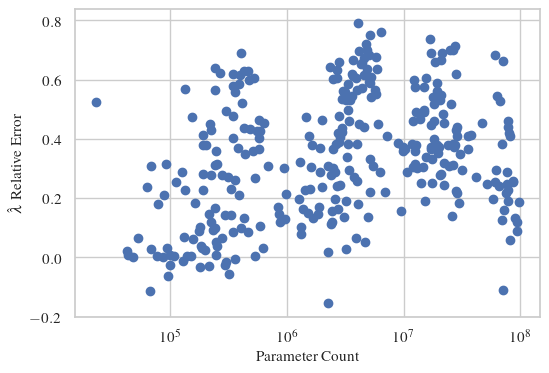

In [50]:
df = df_data
df["lambdahat_relative_error"] = (df["true_lambda"] - df["lambdahat_with_burnin"]) / df["true_lambda"]
fig, ax= plt.subplots(1, 1, figsize=(4, 4))
ax.hist(df["lambdahat_relative_error"])
ax.set_xlabel("$\hat{\lambda}$ Relative Error")
ax.set_ylabel("Count")
savefig_fn(fig, "lambdahat_relative_error_histogram.pdf")

fig, ax= plt.subplots(1, 1, figsize=(6, 4))
ax.scatter(df["model_dim"], df["lambdahat_relative_error"])
ax.set_xscale("log")
ax.set_xlabel("Parameter Count")
ax.set_ylabel("$\hat{\lambda}$ Relative Error")
savefig_fn(fig, "lambdahat_relative_error_scatterplot.pdf")


Text(0.5, 0, 'Number of DLN Hidden Layers')

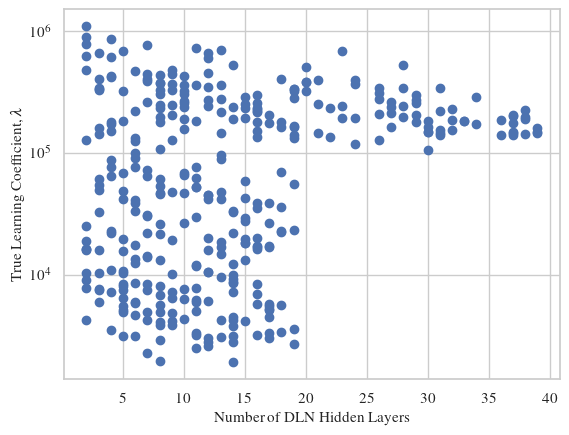

In [48]:
df = df_data
fig, ax = plt.subplots()
ax.scatter(df["num_layers"], df["true_lambda"])
ax.set_yscale("log")
ax.set_ylabel("True Learning Coefficient, $\lambda$")
ax.set_xlabel("Number of DLN Hidden Layers")


Text(0.5, 0, 'Parameter Count')

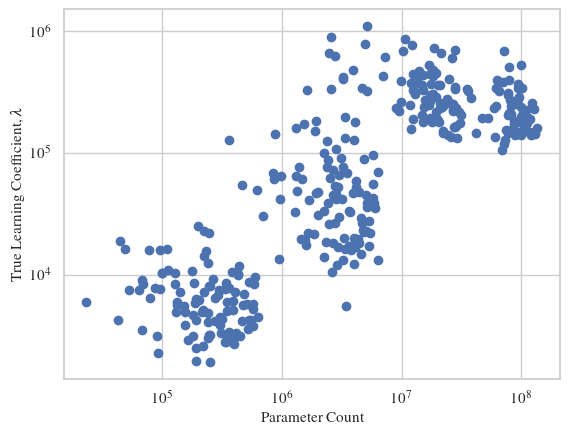

In [54]:
df = df_data
fig, ax = plt.subplots()
ax.scatter(df["model_dim"], df["true_lambda"])
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_ylabel("True Learning Coefficient, $\lambda$")
ax.set_xlabel("Parameter Count")


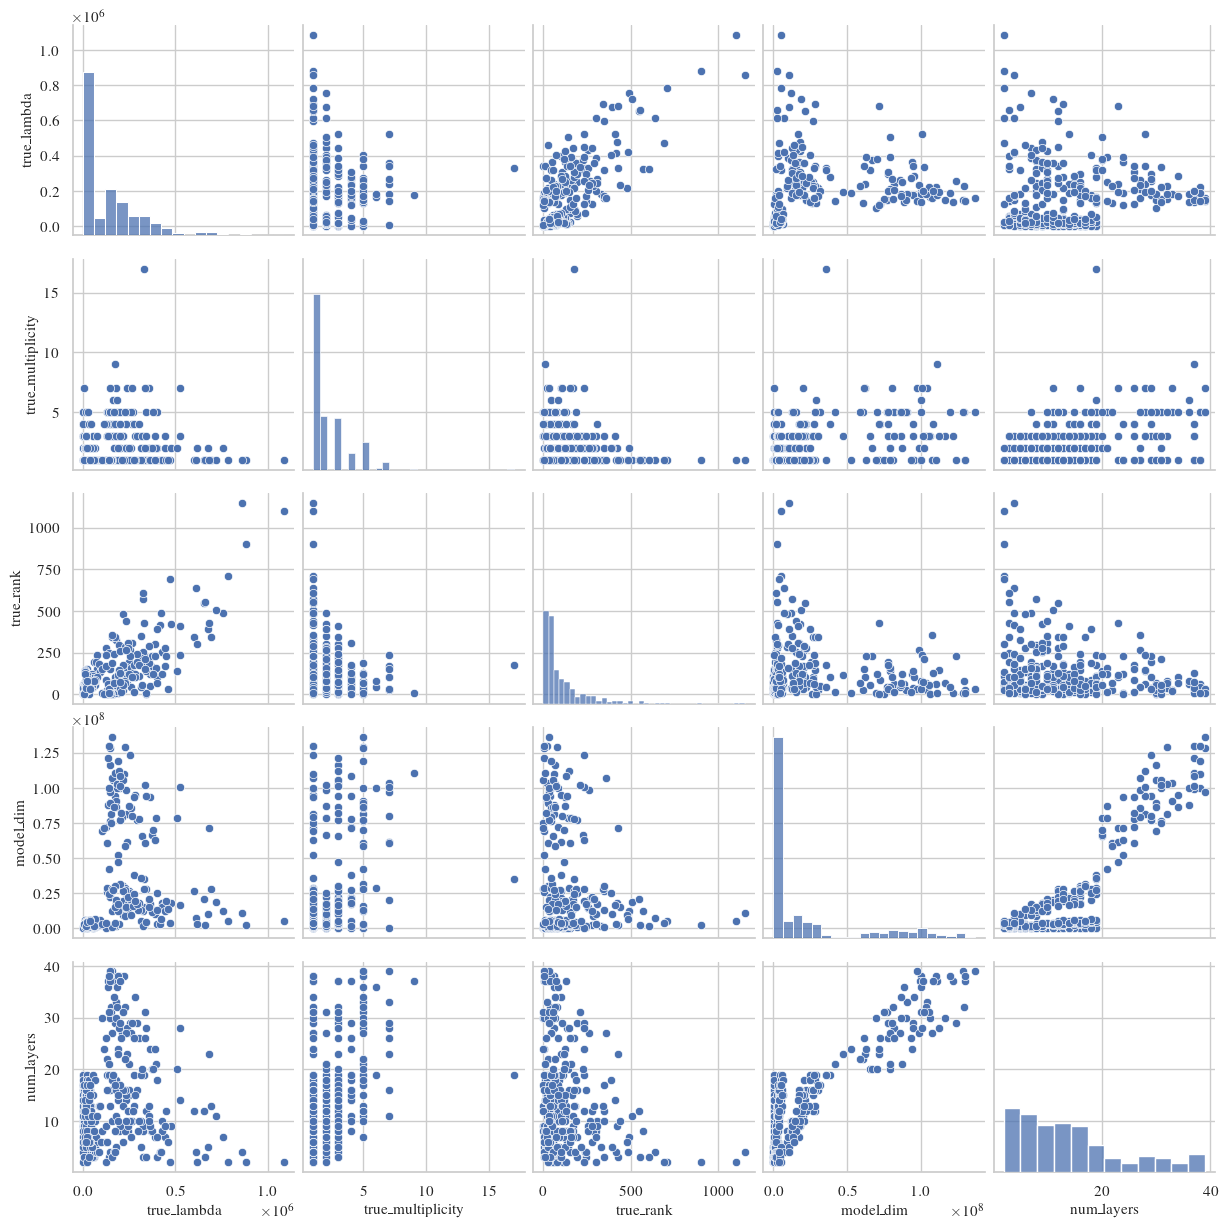

In [42]:
df = df_data[["true_lambda", "true_multiplicity", "true_rank", "model_dim", "num_layers", ]]
sns.pairplot(data=df)